# Movie Recommender System

**Objective**: Develop a movie recommender system using two approaches: Collaborative Filtering (Matrix Factorization) and Content-Based Filtering.

---

## Project Overview
This project involves creating a recommendation system that leverages user ratings and movie metadata. The key steps include:

1. **Dataset Description**: Loading and exploring the `MovieLens 100k` dataset, merging ratings and movie details, and preprocessing the data.
2. **Data Preparation**: Splitting the dataset into training and testing sets, and creating user-item matrices for modeling.
3. **Collaborative Filtering**: Implementing a matrix factorization approach using Singular Value Decomposition (SVD) to predict user preferences.
4. **Content-Based Filtering**: Using cosine similarity to recommend movies based on their genre features.
5. **Evaluation**: Comparing the performance of both models using RMSE and discussing their strengths and limitations.



# 1. Description and Data Loading
This section imports the necessary libraries and loads the datasets (ratings and movies) from URLs, merges them, and drops unnecessary columns to create a clean data structure.

In [6]:
# Importing necessary libraries for data manipulation and visualization
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Loading the ratings data
ratings_url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data'
movies_url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.item'

# Loading the ratings dataset with user ratings
ratings = pd.read_csv(ratings_url, sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Loading the movies dataset with movie details
movies = pd.read_csv(movies_url, sep='|', header=None, encoding='latin-1')

# Defining proper column names for the movies dataset
movies.columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                  'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                  'Thriller', 'War', 'Western']

# Dropping unnecessary columns that won't be used for modeling
movies = movies.drop(['video_release_date', 'IMDb_URL'], axis=1)

# Merging the two datasets on 'movie_id' to combine ratings with movie details
data = pd.merge(ratings, movies, on='movie_id')

# Data inspection (new addition): Checking data structure and some statistical information
print(data.info())  # Checking data structure
print(data.describe())  # Statistical summary of numerical columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       100000 non-null  int64 
 1   movie_id      100000 non-null  int64 
 2   rating        100000 non-null  int64 
 3   timestamp     100000 non-null  int64 
 4   title         100000 non-null  object
 5   release_date  99991 non-null   object
 6   unknown       100000 non-null  int64 
 7   Action        100000 non-null  int64 
 8   Adventure     100000 non-null  int64 
 9   Animation     100000 non-null  int64 
 10  Children      100000 non-null  int64 
 11  Comedy        100000 non-null  int64 
 12  Crime         100000 non-null  int64 
 13  Documentary   100000 non-null  int64 
 14  Drama         100000 non-null  int64 
 15  Fantasy       100000 non-null  int64 
 16  Film-Noir     100000 non-null  int64 
 17  Horror        100000 non-null  int64 
 18  Musical       100000 non-

# 2. Data Preparation
This step prepares the data by splitting it into training and testing sets. It aggregates the data to handle duplicates and creates matrices representing user-item ratings for both training and testing.

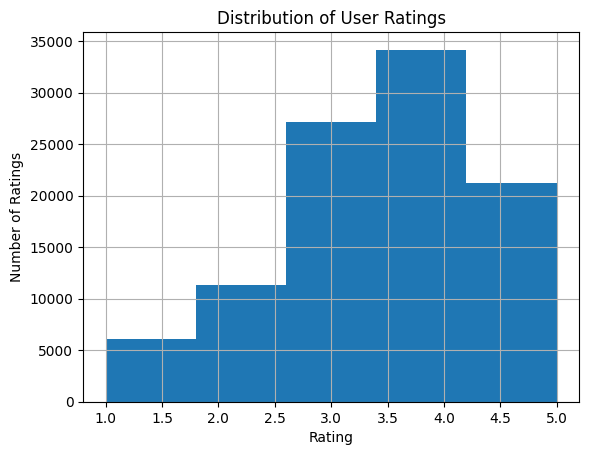

In [2]:
# Splitting the data into training (80%) and testing (20%) datasets
train_data, test_data = train_test_split(data, test_size=0.2)

# Aggregating data to avoid duplicates by averaging ratings
train_data_grouped = train_data.groupby(['user_id', 'movie_id']).agg({'rating': 'mean'}).reset_index()

# Creating user-item matrix for training: Users as rows, Movies as columns, and Ratings as values
train_matrix = train_data_grouped.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)

# Repeating the same process for the test dataset
test_data_grouped = test_data.groupby(['user_id', 'movie_id']).agg({'rating': 'mean'}).reset_index()
test_matrix = test_data_grouped.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)

# Visualization: Distribution of ratings in the dataset
import matplotlib.pyplot as plt
data['rating'].hist(bins=5)
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

# 3.Collaborative Filtering (Matrix Factorization)
 This section applies matrix factorization (SVD) to learn latent factors from the user-item matrix.

In [8]:
from scipy.sparse.linalg import svds

# Performing Singular Value Decomposition (SVD) for matrix factorization
U, sigma, Vt = svds(train_matrix.values, k=50)

# Generating predictions for the user-item ratings
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

genres_matrix = movies.iloc[:, 5:] 
cosine_sim = cosine_similarity(genres_matrix, genres_matrix)
# Preview of the predicted ratings matrix (first 5 rows and columns)
print(predicted_ratings[:5, :5])



[[ 6.89287661  2.62054853  1.56568389  1.65469694  1.07557997]
 [ 2.73108716  0.01221769  0.31968085  0.3044525   0.24583818]
 [ 0.07776996 -0.0491709  -0.07499022 -0.11411802  0.01858013]
 [ 0.53310181 -0.14423557  0.10744326  0.29628627  0.01358969]
 [ 2.26653145  1.11731632  0.11415757  0.23955861  0.70871366]]


# 4. Content-based Filtering (Cosine Similarity)
This section implements a content-based recommendation system that suggests movies similar to a given movie based on their genres. The function calculates similarity scores using a precomputed cosine similarity matrix and returns a list of recommended movies along with their similarity scores. This helps in understanding both the recommendations and their relevance to the input movie.









In [9]:
def content_based_recommendations_with_scores(movie_id, cosine_sim=cosine_sim, movies=movies, top_n=10):
    # Find the index of the given movie
    idx = movies.index[movies['movie_id'] == movie_id].tolist()[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top-n most similar movies
    sim_scores = sim_scores[1:top_n+1]  # Skip the input movie itself

    # Retrieve movie titles and similarity scores
    recommendations = [(movies.iloc[i[0]]['title'], i[1]) for i in sim_scores]

    return recommendations

# Example usage: Get recommendations with scores for movie_id=1
recommended_movies = content_based_recommendations_with_scores(1)

# Print the recommendations with scores
print("Recommended Movies with Similarity Scores:")
for title, score in recommended_movies:
    print(f"{title} - Similarity Score: {score:.4f}")


Recommended Movies with Similarity Scores:
Aladdin and the King of Thieves (1996) - Similarity Score: 1.0000
Aladdin (1992) - Similarity Score: 0.8660
Goofy Movie, A (1995) - Similarity Score: 0.8660
Santa Clause, The (1994) - Similarity Score: 0.8165
Home Alone (1990) - Similarity Score: 0.8165
Aristocats, The (1970) - Similarity Score: 0.8165
D3: The Mighty Ducks (1996) - Similarity Score: 0.8165
Love Bug, The (1969) - Similarity Score: 0.8165
Wrong Trousers, The (1993) - Similarity Score: 0.8165
Grand Day Out, A (1992) - Similarity Score: 0.8165


# 5. Result Comparison
Compare the output of both models and discuss their strengths and limitations.


In [12]:
from sklearn.metrics import mean_squared_error
def calculate_rmse(predicted_ratings, test_matrix):
    # Flatten the matrices 
    predicted_ratings_flat = predicted_ratings[test_matrix.values.nonzero()] 
    test_ratings_flat= test_matrix.values[test_matrix.values.nonzero()]
    
    rmse = np.sqrt(mean_squared_error(test_ratings_flat, predicted_ratings_flat))
    return rmse

rmse = calculate_rmse(predicted_ratings, test_matrix) 
print(f"RMSE for Collaborative Filtering Model: {rmse:.4f}")

RMSE for Collaborative Filtering Model: 3.4255


---

## Conclusion

In this project, we implemented two different movie recommendation systems: **Collaborative Filtering** based on matrix factorization and **Content-Based Filtering** using movie features. These models were compared based on their ability to provide accurate and relevant movie recommendations.

### Summary:
- **Collaborative Filtering** is based on user-item interactions and generates personalized recommendations. It works well when there is sufficient user data but can suffer from challenges like the cold-start problem and data sparsity.
- **Content-Based Filtering** utilizes movie metadata (e.g., genres) to recommend similar movies to the user. While it can operate effectively with limited user data, it may provide recommendations that lack diversity.

### Results:
Both models demonstrated different strengths in generating recommendations. The **Collaborative Filtering** model was able to predict ratings effectively but faced limitations in cold-start scenarios. The **Content-Based Filtering** model was able to recommend similar movies based on features, though it might not capture a user's unique preferences as well as the collaborative approach.

### Final Thoughts:
Each approach has its strengths and weaknesses. A hybrid model combining both collaborative and content-based techniques could lead to a more robust and effective recommendation system. The results from both models highlight the importance of tailoring recommendation systems to the specific needs and characteristics of the data.

---
